In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import gc
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

PATH = '../'

In [2]:
%%time
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'Track 1/test.csv')
submission = pd.read_csv(PATH + 'Track 1/submission.csv')

CPU times: user 1.61 s, sys: 132 ms, total: 1.74 s
Wall time: 1.74 s


In [3]:
def smape(satellite_predicted_values, satellite_true_values): 
    # the division, addition and subtraction are pointwise 
    return np.mean(np.abs(satellite_predicted_values - satellite_true_values) / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values)))

In [4]:
training_columns = ['epoch', 'sat_id', 'x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']
prediction_columns = ['x','y','z','Vx', 'Vy', 'Vz', 'epoch']
X = train.loc[:, training_columns]
y = train.loc[:, prediction_columns]
Xtest = test.loc[:, training_columns]

In [5]:
X['r'] = np.sqrt(X.x_sim**2 + X.y_sim**2 + X.z_sim**2)
Xtest['r'] = np.sqrt(Xtest.x_sim**2 + Xtest.y_sim**2 + Xtest.z_sim**2)
y['r'] = np.sqrt(y.x**2 + y.y**2 + y.z**2)

X['phi'] = np.arctan(X.y_sim/X.x_sim)
Xtest['phi'] = np.arctan(Xtest.y_sim/Xtest.x_sim)
y['phi'] = np.arctan(y.y/y.x)

X['theta'] = np.arccos(X.z_sim/X.r)
Xtest['theta'] = np.arccos(Xtest.z_sim/Xtest.r)
y['theta'] = np.arccos(y.z/y.r)


X['Vr'] = np.sqrt(X.Vx_sim**2 + X.Vy_sim**2 + X.Vz_sim**2)
Xtest['Vr'] = np.sqrt(Xtest.Vx_sim**2 + Xtest.Vy_sim**2 + Xtest.Vz_sim**2)
y['Vr'] = np.sqrt(y.Vx**2 + y.Vy**2 + y.Vz**2)

X['Vphi'] = np.arctan(X.Vy_sim/X.Vx_sim)
Xtest['Vphi'] = np.arctan(Xtest.Vy_sim/Xtest.Vx_sim)
y['Vphi'] = np.arctan(y.Vy/y.Vx)

X['Vtheta'] = np.arccos(X.Vz_sim/X.Vr)
Xtest['Vtheta'] = np.arccos(Xtest.Vz_sim/Xtest.Vr)
y['Vtheta'] = np.arccos(y.Vz/y.Vr)

In [6]:
def extractTimeFeats(data):
    timeFeats = data['epoch'].apply(lambda x: str(x).split('T')[1].split('.')[0].split(':')).values
    h,m,s = [],[],[]
    for feat in timeFeats:
        h.append(feat[0]); m.append(feat[1]); s.append(feat[2])
    return h,m,s
h,m,s = extractTimeFeats(X)
X.loc[:, 'h'] = list(map(int, h)); X.loc[:, 'm'] = list(map(int, m)); X.loc[:, 's'] =list(map(int, s))
X.drop(columns = 'epoch', inplace = True)

h,m,s = extractTimeFeats(Xtest)
Xtest.loc[:, 'h'] = list(map(int, h)); Xtest.loc[:, 'm'] = list(map(int, m)); Xtest.loc[:, 's'] = list(map(int, s))
Xtest.drop(columns = 'epoch', inplace = True)

In [82]:
ytr

,x,y,z,Vx,Vy,Vz,epoch,r,phi,theta,Vr,Vphi,Vtheta
35751,7023.731947,-4716.124093,1703.602970,-3.473291,-6.651652,-4.093998,2014-01-01T00:00:00.000,8630.000000,-0.591311,1.372086,8.548044,1.089571,2.070243
35752,513.574750,-10034.734578,-3382.609264,-6.188187,-1.951347,-3.710492,2014-01-01T00:20:30.131,10601.966917,-1.519661,1.895528,7.474568,0.305465,2.090261
35753,-6789.787579,-10462.630158,-7082.237439,-5.477301,0.853387,-2.349018,2014-01-01T00:41:00.263,14343.149317,0.995155,2.087218,6.020547,-0.154562,1.971609
35754,-12825.838305,-8602.292516,-9337.496227,-4.348508,2.003710,-1.384288,2014-01-01T01:01:30.394,18046.894484,0.590790,2.114608,4.984037,-0.431783,1.852242
35755,-17554.786297,-5800.696706,-10617.270177,-3.370555,2.481486,-0.736525,2014-01-01T01:22:00.526,21320.061684,0.319139,2.092081,4.249810,-0.634626,1.744984
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37054,-15055.905953,25756.275769,3872.758821,2.338786,0.501789,1.307166,2014-01-19T12:33:20.971,30084.286703,-1.041812,1.441708,2.725875,0.211347,1.070666
37055,-12019.104513,26078.915907,5430.649153,2.592795,0.014626,1.219538,2014-01-19T12:53:51.103,29224.316560,-1.138936,1.383883,2.865323,0.005641,1.131150
37056,-8692.647489,25770.101284,6856.396819,2.808334,-0.526710,1.090923,2014-01-19T13:14:21.234,28047.645496,-1.245466,1.323838,3.058476,-0.185399,1.206075
37057,-5130.321397,24755.449679,8093.371510,2.973703,-1.135647,0.910259,2014-01-19T13:34:51.366,26545.341377,-1.366449,1.260975,3.310766,-0.364803,1.292270


                                 SARIMAX Results                                  
Dep. Variable:                         Vr   No. Observations:                 1308
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood                 382.910
Date:                    Thu, 06 Feb 2020   AIC                           -759.820
Time:                            15:45:31   BIC                           -744.292
Sample:                                 0   HQIC                          -753.996
                                   - 1308                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9983      0.001   1609.003      0.000       0.997       1.000
ma.S.L24       0.5014      0.016     31.336      0.000       0.470       0.533
sigma2         0.028

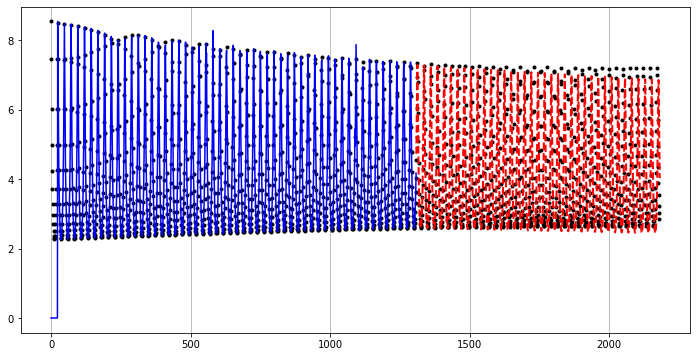

In [85]:
#ARIMA PLAYGROUD
#skip

import statsmodels.api as sm

sat_id = 37
satX = X[X['sat_id'] == sat_id]
satY = y[X['sat_id'] == sat_id]
satXtest = Xtest[Xtest['sat_id'] == sat_id]
size = int(satX.shape[0] * trainSize)
Xtr, Xval = satX.iloc[:size, :], satX.iloc[size:, :]
ytr, yval = satY.iloc[:1*size, :], satY.iloc[size:,:]
# for i in range(nTargets):
i = 10
mod = sm.tsa.statespace.SARIMAX(ytr.iloc[:,i], order=(0,0,0), seasonal_order=(1,0,1,24), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

nforecast = satX.shape[0] - size
predict = res.get_prediction(end=mod.nobs + nforecast)
predict.index =  ytr.iloc[:,i].index
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(satY.iloc[:,i].reset_index(drop=True), 'k.')

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'blue')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', color='red', linestyle='--', linewidth=2)
# ax.fill_between(idx, predict_ci[:, 0], predict_ci[:, 1], alpha=0.15)

In [12]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.cluster import KMeans
import statsmodels.api as sm
from collections import defaultdict

RND_SEED = 44
sat_preds = {}
trainSize = 0.6
cluster = KMeans(n_clusters=24, tol = 1e-3, algorithm = 'elkan', random_state=RND_SEED)
smp = []
nTargets = 6
rfc = Ridge(alpha=0.01)
for sat_id in tqdm(Xtest['sat_id'].unique()):
    satX = X[X['sat_id'] == sat_id]
    satY = y[X['sat_id'] == sat_id]
    satXtest = Xtest[Xtest['sat_id'] == sat_id]

    size = int(satX.shape[0] * trainSize)
    ytr, yval = satY.iloc[:1*size, :], satY.iloc[size:,:]
    smp_sat = defaultdict(list)
    for i in range(6, 6+nTargets):
        model1 = CatBoostRegressor(iterations=200,
                          learning_rate=0.3,
                          depth=5,
                          verbose=False)
        Xtr, Xval = satX.iloc[:size, :-3], satX.iloc[size:, :-3]
        model1.fit(Xtr, ytr.iloc[:, i])
        model2 = Ridge(alpha=0.01)
        model2.fit(Xtr, ytr.iloc[:, i])
        pred1 = pd.Series(model1.predict(Xval))
        pred2 = pd.Series(model2.predict(Xval))
        pred1.index = yval.iloc[:, i].index
        pred2.index = yval.iloc[:, i].index
        ##arima
        try:
            mod = sm.tsa.statespace.SARIMAX(ytr.iloc[:,i], order=(0,0,0), seasonal_order=(1,0,1,24), simple_differencing=True)
            res = mod.fit(disp=False)
            nforecast = satX.shape[0] - size
            preda = res.get_forecast(steps = nforecast)
            pred3 = preda.predicted_mean
            assert size+len(pred3) == satY.shape[0]
            assert len(pred3) == yval.iloc[:, i].shape[0]
            pred3.index = yval.iloc[:, i].index
        except Exception as e:
            try:
                mod = sm.tsa.statespace.SARIMAX(ytr.iloc[:,i], order=(0,0,0), seasonal_order=(1,0,0,24), simple_differencing=True)
                res = mod.fit(disp=False)
                nforecast = satX.shape[0] - size
                preda = res.get_forecast(steps = nforecast)
                pred3 = preda.predicted_mean
                assert size+len(pred3) == satY.shape[0]
                assert len(pred3) == yval.iloc[:, i].shape[0]
                pred3.index = yval.iloc[:, i].index
            except Exception as e:
                try:
                    mod = sm.tsa.statespace.SARIMAX(ytr.iloc[:,i], order=(0,0,0), seasonal_order=(1,0,2,24), simple_differencing=True)
                    res = mod.fit(disp=False)
                    nforecast = satX.shape[0] - size
                    preda = res.get_forecast(steps = nforecast)
                    pred3 = preda.predicted_mean
                    assert size+len(pred3) == satY.shape[0]
                    assert len(pred3) == yval.iloc[:, i].shape[0]
                    pred3.index = yval.iloc[:, i].index
                except Exception:
                    pred3 = pred2 
        ypred = (pred1 + 2*  pred3) / 3
        sat_preds[(sat_id, i)] = pd.concat([pred1, pred2, pred3, ypred], axis = 1)#.rename(
#             columns=['catboost', 'ridge', 'arima'])
        smp.append(smape(ypred, yval.iloc[:, i]))
        smp_sat['total'].append(smape(ypred, yval.iloc[:, i]))
        smp_sat['catboost'].append(smape(pred1, yval.iloc[:, i]))
        smp_sat['ridge'].append(smape(pred2, yval.iloc[:, i]))
        smp_sat['arima'].append(smape(pred3, yval.iloc[:, i]))
    print(sat_id, 100*(1- np.mean(smp_sat['catboost'])), 
          100*(1- np.mean(smp_sat['ridge'])), 100*(1- np.mean(smp_sat['arima'])), 100*(1- np.mean(smp)))

1 94.28662001866378 88.07266702571856 94.25531191501429 95.03611464318492
2 94.79756799927047 88.68927261638736 95.50875856960047 95.32216736640979
3 97.13828917584505 89.24409452845316 96.27554187540143 95.97712819618384
4 88.1958815376854 78.64428931415043 86.81009105869903 93.95210486623002
6 89.67568063040382 82.89458085569576 90.76662302194103 93.33278101976504
9 96.74237584589275 95.09356542851252 97.19233415201471 93.97982342475922
16 97.25222986119665 98.08188594366264 98.60912752850093 94.58971261103993
20 83.63047351369313 77.16926563390362 82.12932189030859 93.22969259571694
22 81.91716456539388 77.6337425922415 84.16220120046424 92.20395032068791
24 97.03146529234952 97.55186275956187 98.36949773172556 92.77313100746251
25 89.32672197950565 84.1261245439836 90.01679375018121 92.51005908489807
26 87.78961957904811 82.12473085335154 84.47548821380204 91.98811127952153
27 89.88538480854398 87.34970469383856 89.1123814586798 91.83523660780935
28 88.6616918766282 82.149275238512

KeyboardInterrupt: 

In [119]:
sat_id = 253
satY = y[X['sat_id'] == sat_id]
delta_df = (satY.shift(-24) - satY).iloc[:-24]

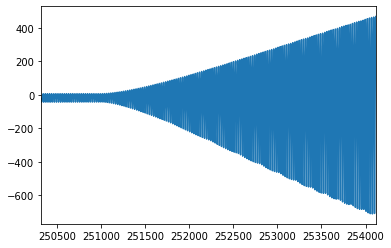

In [120]:
delta_df.x.plot()

In [54]:
#ARIMA PLAYGROUD
#skip

import statsmodels.api as sm

sat_id = 1#253#35
satY = y[X['sat_id'] == sat_id]
delta_df = (satY.shift(-24) - satY).iloc[:-24]
size = int(delta_df.shape[0] * trainSize)
ytr, yval = delta_df.iloc[:size, :], delta_df.iloc[size:,:]
# for i in range(nTargets):
i = 2
mod = sm.tsa.statespace.SARIMAX(ytr.iloc[:,i], order=(0,0,0), seasonal_order=(1,0,1,24), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

nforecast = satY.shape[0] - size
predict = res.get_prediction(end=mod.nobs + nforecast)
predict.index =  ytr.iloc[:,i].index
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(delta_df.iloc[:,i].reset_index(drop=True), 'k.')

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'blue')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', color='red', linestyle='--', linewidth=2)
# ax.fill_between(idx, predict_ci[:, 0], predict_ci[:, 1], alpha=0.15)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [52]:
#ARIMA PLAYGROUD
#skip

import statsmodels.api as sm

sat_id = 1#253#35
satY = y[X['sat_id'] == sat_id]
delta_df = (satY.shift(-24) - satY).iloc[:-24]
size = int(delta_df.shape[0] * trainSize)
ytr, yval = delta_df.iloc[:size, :], delta_df.iloc[size:,:]
# for i in range(nTargets):
i = 6
mod = sm.tsa.statespace.SARIMAX(ytr.iloc[:,i], order=(0,0,0), seasonal_order=(1,0,2,24), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

nforecast = satY.shape[0] - size
predict = res.get_prediction(end=mod.nobs + nforecast)
predict.index =  ytr.iloc[:,i].index
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(delta_df.iloc[:,i].reset_index(drop=True), 'k.')

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'blue')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', color='red', linestyle='--', linewidth=2)
# ax.fill_between(idx, predict_ci[:, 0], predict_ci[:, 1], alpha=0.15)

NameError: name 'delta_df' is not defined

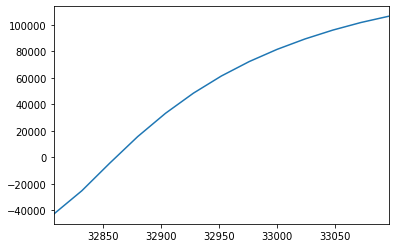

In [141]:
sat_id = 35#253#35
satY = y[X['sat_id'] == sat_id]
satY[satY.index.map(lambda x: x%24==0)].y.plot()

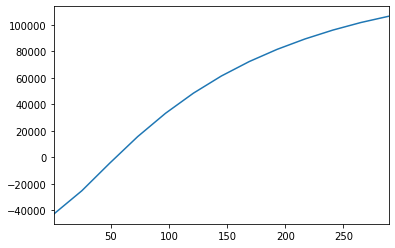

In [166]:
sat_id = 35#253#35
satY = y[X['sat_id'] == sat_id]
satY.reset_index(inplace=True)
# satY[satY.index.map(lambda x: x%24==1)].y.plot()
satY[satY.index.map(lambda x: x%24==1)].y.plot()

                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  744
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood               -3303.104
Date:                    Thu, 06 Feb 2020   AIC                           6612.208
Time:                            13:35:52   BIC                           6626.044
Sample:                                 0   HQIC                          6617.541
                                    - 744                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       1.0000   1.19e-06   8.43e+05      0.000       1.000       1.000
ma.S.L24       0.9685      0.002    559.813      0.000       0.965       0.972
sigma2       262.920

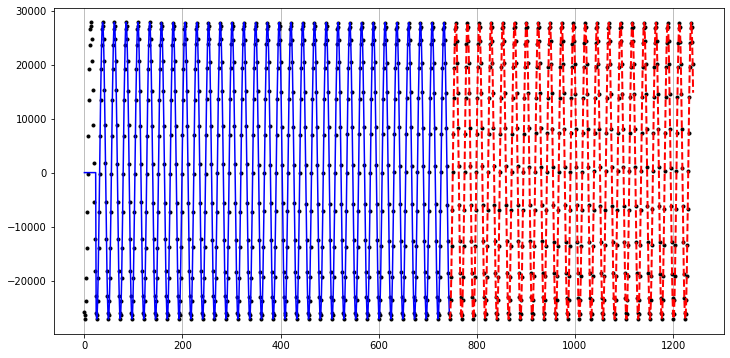

In [11]:
#PROPHET PLAYGROUD
#skip

from fbprophet import Prophet
import statsmodels.api as sm

sat_id = 57
trainSize = 0.6
satX = X[X['sat_id'] == sat_id]
satY = y[X['sat_id'] == sat_id]
satXtest = Xtest[Xtest['sat_id'] == sat_id]
size = int(satX.shape[0] * trainSize)
Xtr, Xval = satX.iloc[:size, :], satX.iloc[size:, :]
ytr, yval = satY.iloc[:1*size, :], satY.iloc[size:,:]
# for i in range(nTargets):
i = 1
model = Prophet()
mod = sm.tsa.statespace.SARIMAX(ytr.iloc[:,i], order=(0,0,0), seasonal_order=(1,0,1,24), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

nforecast = satX.shape[0] - size
predict = res.get_prediction(end=mod.nobs + nforecast)
predict.index =  ytr.iloc[:,i].index
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(satY.iloc[:,i].reset_index(drop=True), 'k.')

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'blue')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', color='red', linestyle='--', linewidth=2)
# ax.fill_between(idx, predict_ci[:, 0], predict_ci[:, 1], alpha=0.15)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


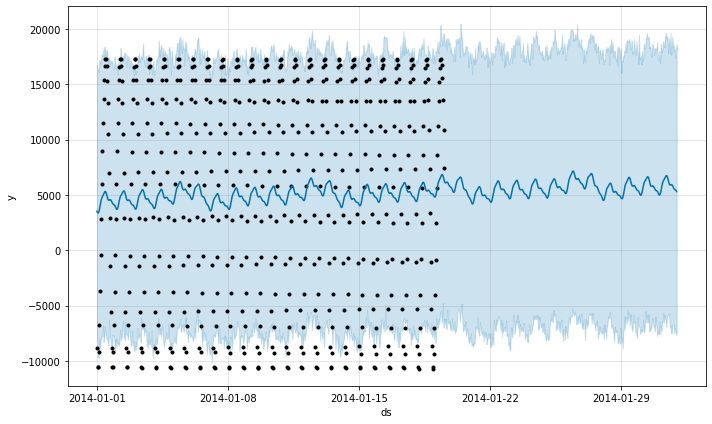

In [48]:
#PROPHET PLAYGROUD
#skip

from fbprophet import Prophet
import statsmodels.api as sm

sat_id = 0
trainSize = 0.6
satX = X[X['sat_id'] == sat_id]
satY = y[X['sat_id'] == sat_id]
satXtest = Xtest[Xtest['sat_id'] == sat_id]
size = int(satX.shape[0] * trainSize)
Xtr, Xval = satX.iloc[:size, :], satX.iloc[size:, :]
ytr, yval = satY.iloc[:1*size, :], satY.iloc[size:,:]
# for i in range(nTargets):
i = 0
model = Prophet()
df = pd.concat([ytr.epoch, ytr.iloc[:,i]], axis =1 )
df = df.rename(columns={'epoch': "ds", 'x': 'y'})
model.fit(df)

future = pd.DataFrame(satY.epoch.rename('ds')).reset_index(drop=True)

fcst = model.predict(future)
fig = model.plot(fcst)

In [248]:
ytr.head()

,x,y,z,Vx,Vy,Vz,epoch,r,phi,theta,Vr,Vphi,Vtheta
0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,2014-01-01T00:00:00.000,26080.000000,-0.976977,2.489472,4.406588,1.336672,2.047528
1,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,2014-01-01T00:46:43.000,26686.896582,-0.152090,2.729408,4.326931,1.500094,1.712898
2,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,2014-01-01T01:33:26.001,28338.043990,0.766218,2.596977,4.120966,-1.502359,1.394401
3,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,2014-01-01T02:20:09.001,30651.371610,1.153792,2.313120,3.854871,-1.361787,1.107681
4,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,2014-01-01T03:06:52.002,33244.665434,1.342582,2.036848,3.582143,-1.195565,0.857205


In [391]:
smp_total = []
for sat_id in tqdm(Xtest['sat_id'].unique()):
    trainSize = 0.6
    satX = X[X['sat_id'] == sat_id]
    satY = y[X['sat_id'] == sat_id]
    satXtest = Xtest[Xtest['sat_id'] == sat_id]
    size = int(satX.shape[0] * trainSize)
    Xtr, Xval = satX.iloc[:size, :], satX.iloc[size:, :]
    ytr, yval = satY.iloc[:size, :], satY.iloc[size:, :]
    smp = []
    for j in range(6):
        try:
            target = ytr.iloc[:, j]
            yvalj = yval.iloc[:, j]
        #     plt.plot(target)

            from sklearn.model_selection import train_test_split
            li = [(target.iloc[0+i:-24+i]).reset_index(drop=True).rename('r{}'.format(24-i)) for i in range(24)]
            mean = target.rolling(24).apply(lambda x: x.mean()).rename('mean').iloc[23:-1].reset_index(drop=True)
            std = target.rolling(24).apply(lambda x: x.std()).rename('std').iloc[23:-1].reset_index(drop=True)
            li.append(mean)
            li.append(std)
            x = pd.concat(li, axis = 1)
            ya = target.shift(-24).iloc[:-24].reset_index(drop=True)
            x1, x2, y1, y2 = train_test_split(x, ya, shuffle=False, train_size=0.9)

            from sklearn.linear_model import Ridge
            ridge = Ridge(alpha = 0.001, normalize=False)
            ridge.fit(x, ya)
            from sklearn.metrics import mean_squared_error as mse
            mse(y2, ridge.predict(x2))

            # import matplotlib.pyplot as plt
            # %matplotlib inline
            # plt.rcParams['figure.figsize'] = 15, 5
            # plt.plot(ridge.predict(x2))
            # plt.plot(y2.values)

            for i in range(len(yvalj)):
                mean = target.tail(25).rolling(24).apply(lambda x: x.mean()).rename('mean').iloc[-1]
                std = target.tail(25).rolling(24).apply(lambda x: x.std()).rename('std').iloc[-1]
                li = [target.iloc[-24+i] for i in range(24)]
                li.append(mean)
                li.append(std)
                x = np.array(li).reshape(1, len(li))
                ya = pd.Series(ridge.predict(x))
                ya.index = [target.index[-1]+1]
                target = target.append(pd.Series(ya))

        #     import matplotlib.pyplot as plt
        #     %matplotlib inline
        #     plt.rcParams['figure.figsize'] = 15, 5
        #     plt.plot(target[-yvalj.shape[0]:])
        #     plt.plot(yvalj)
        
            smp.append(smape(target[-yvalj.shape[0]:], yvalj))
            smp_total.append(smape(target[-yvalj.shape[0]:], yvalj))
        except Exception:
            pass
    print(sat_id, 100*(1- np.mean(smp)), 100*(1- np.mean(smp_total)))

1 70.20120989210439 70.20120989210439
2 52.58534868545161 61.393279288778004
3 74.64288344060041 65.80981400605214
4 77.59889347950156 68.75708387441448
6 82.66358813029298 71.53838472559019
9 99.21630134244721 76.15137082839969
16 97.51209714634312 79.20290315953447
20 67.75250740119803 77.7716036897424
22 83.50330624998371 78.40845952976923
24 99.29051670031852 80.49666524682415
25 72.72707574904435 79.79033892884418
26 90.02024504074238 80.6428311048357
27 16.34707273253807 75.69700353773587
28 95.7842197141247 77.13180469319221
29 99.41666013129782 78.61746172239926
32 75.83969967027554 78.44385159414152
34 99.68262977695024 79.69319148724792
35 88.80392296312051 80.1993432359075
36 99.91028753704778 81.23676135702014
37 45.31135614871925 79.4404910966051
38 70.24714407841519 79.00271266716749
39 99.62015550544861 79.93986915981664
40 99.96102201540475 80.81035406658134
41 46.489693204402215 79.61033095951213
42 99.4299413624535 80.4084360764091
44 99.43162090109413 81.144817424461

422 88.1988551849102 87.86036434733718
423 99.78020039140924 87.9173516112929
424 99.84389443769682 87.97409963425756
426 99.85811939473942 88.03037754946111
428 99.94556601284363 88.08653711802378
435 98.70581205485941 88.13635388864225
436 99.95265329113258 88.19152727106633
437 66.95256626736443 88.0928179248059
438 80.1186730285046 88.05592905096024
440 79.381345438384 88.01598469050326
443 58.70218719484362 87.8816204544651
446 99.92204679383245 87.9365577609565
448 95.15480302562256 87.96934312930472
449 99.82810949911435 88.02296226888186
450 52.044466111384914 87.86101855024346
452 50.951807069921195 87.69562999992088
454 67.06573948180305 87.60360074853895
455 97.05724432265984 87.64558584213238
456 98.12379269290003 87.69191542290217
457 98.55379298776644 87.73972999765579
460 92.52401304593475 87.76069836748024
462 99.96456161657224 87.81395158893082
464 90.80192014628976 87.82693334949863
465 99.86308945556976 87.87900035500435
466 88.4677873611018 87.88153640815337
467 98.

In [392]:
smp_total = []
for sat_id in tqdm(Xtest['sat_id'].unique()):
    trainSize = 0.6
    satX = X[X['sat_id'] == sat_id]
    satY = y[X['sat_id'] == sat_id]
    satXtest = Xtest[Xtest['sat_id'] == sat_id]
    size = int(satX.shape[0] * trainSize)
    Xtr, Xval = satX.iloc[:size, :], satX.iloc[size:, :]
    ytr, yval = satY.iloc[:size, :], satY.iloc[size:, :]
    smp = []
    for j in range(6):
        try:
            target = ytr.iloc[:, j]
            yvalj = yval.iloc[:, j]
        #     plt.plot(target)

            from sklearn.model_selection import train_test_split
            li = [(target.iloc[0+i:-48+i]).reset_index(drop=True).rename('r{}'.format(48-i)) for i in range(48)]
            mean = target.rolling(48).apply(lambda x: x.mean()).rename('mean').iloc[47:-1].reset_index(drop=True)
            std = target.rolling(48).apply(lambda x: x.std()).rename('std').iloc[47:-1].reset_index(drop=True)
            li.append(mean)
            li.append(std)
            x = pd.concat(li, axis = 1)
            ya = target.shift(-48).iloc[:-48].reset_index(drop=True)
            x1, x2, y1, y2 = train_test_split(x, ya, shuffle=False, train_size=0.9)

            from sklearn.linear_model import Ridge
            ridge = Ridge(alpha = 0.001, normalize=False)
            ridge.fit(x, ya)
            from sklearn.metrics import mean_squared_error as mse
            mse(y2, ridge.predict(x2))

            # import matplotlib.pyplot as plt
            # %matplotlib inline
            # plt.rcParams['figure.figsize'] = 15, 5
            # plt.plot(ridge.predict(x2))
            # plt.plot(y2.values)

            for i in range(len(yvalj)):
                mean = target.tail(49).rolling(48).apply(lambda x: x.mean()).rename('mean').iloc[-1]
                std = target.tail(49).rolling(48).apply(lambda x: x.std()).rename('std').iloc[-1]
                li = [target.iloc[-48+i] for i in range(48)]
                li.append(mean)
                li.append(std)
                x = np.array(li).reshape(1, len(li))
                ya = pd.Series(ridge.predict(x))
                ya.index = [target.index[-1]+1]
                target = target.append(pd.Series(ya))
            
        #     import matplotlib.pyplot as plt
        #     %matplotlib inline
        #     plt.rcParams['figure.figsize'] = 15, 5
        #     plt.plot(target[-yvalj.shape[0]:])
        #     plt.plot(yvalj)
        
            smp.append(smape(target[-yvalj.shape[0]:], yvalj))
            smp_total.append(smape(target[-yvalj.shape[0]:], yvalj))
        except Exception:
            pass
    print(sat_id, 100*(1- np.mean(smp)), 100*(1- np.mean(smp_total)))

1 85.065448482099 85.065448482099
2 62.20108315299453 72.59397648440566
3 66.42412773905633 70.41638280957648
4 74.14700853882485 71.38958952155431
6 95.81698170128135 76.44353273115301
9 99.27578002693241 80.35763226757233
16 90.19342990065384 81.79701728704768
20 56.936346288524135 78.6233146063851
22 81.97393347850898 79.00262995039913
24 99.51536929317666 81.08867123949514
25 60.07380242744635 79.14883719530603
26 94.37617853379288 80.43565477320632
27 2.6701123886699207 74.37600211986583
28 96.55882570288775 75.97957972827705
29 99.45636728743388 77.56228450754604
32 67.71412221699804 76.94029531024827
34 99.57242731643278 78.28477839972459
35 91.82844836964713 79.04423652887913
36 99.9358519556332 80.15352584357403
37 45.34464993412818 78.39845646998852
38 80.14991968969257 78.48252670453432
39 98.76704622086821 79.4115886671145
40 99.87104248186567 80.30762314075322
41 50.98754413111811 79.27522599252664
42 99.52957213646482 80.0963481334971
44 99.50359734331315 80.8524747260873

KeyboardInterrupt: 

<h1>Submission</h1>

In [ ]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

for sat_id in tqdm(Xtest['sat_id'].unique()):
    satX = X[X['sat_id'] == sat_id]
    satY = y[X['sat_id'] == sat_id]
    satXtest = Xtest[Xtest['sat_id'] == sat_id]
    for j in range(6):
        try:
            target = satY.iloc[:, j]
            li = [(target.iloc[0+i:-24+i]).reset_index(drop=True).rename('r{}'.format(24-i)) for i in range(24)]
            mean = target.rolling(24).apply(lambda x: x.mean()).rename('mean').iloc[23:-1].reset_index(drop=True)
            std = target.rolling(24).apply(lambda x: x.std()).rename('std').iloc[23:-1].reset_index(drop=True)
            li.append(mean)
            li.append(std)
            x = pd.concat(li, axis = 1)
            ya = target.shift(-24).iloc[:-24].reset_index(drop=True)

            from sklearn.linear_model import Ridge
            ridge = Ridge(alpha = 0.001, normalize=False)
            ridge.fit(x, ya)

            for i in range(satXtest.shape[0]):
                mean = target.tail(25).rolling(24).apply(lambda x: x.mean()).rename('mean').iloc[-1]
                std = target.tail(25).rolling(24).apply(lambda x: x.std()).rename('std').iloc[-1]
                li = [target.iloc[-24+i] for i in range(24)]
                li.append(mean)
                li.append(std)
                x = np.array(li).reshape(1, len(li))
                ya = pd.Series(ridge.predict(x))
                ya.index = [target.index[-1]+1]
                target = target.append(pd.Series(ya))
                
            target = target[-satXtest.shape[0]:]
            target.index = satXtest.index
            submission.loc[satXtest.index, submission.columns[j+1]] = target
        except Exception as e:
            print(sat_id, j, e)
            try:
                mod = sm.tsa.statespace.SARIMAX(satY.iloc[:, j], order=(0,0,0), seasonal_order=(1,0,1,24), simple_differencing=True)
                res = mod.fit(disp=False)
            except Exception as e:
                try:
                    mod = sm.tsa.statespace.SARIMAX(satY.iloc[:, j], order=(0,0,0), seasonal_order=(1,0,0,24), simple_differencing=True)
                    res = mod.fit(disp=False)
                except Exception as e:
                    mod = sm.tsa.statespace.SARIMAX(satY.iloc[:, j], order=(0,0,0), seasonal_order=(1,0,2,24), simple_differencing=True)
                    res = mod.fit(disp=False)
            nforecast = satXtest.shape[0]
            pred = res.get_forecast(steps = nforecast)
            ypred = pred.predicted_mean
            assert len(ypred) == satXtest.iloc[:, j].shape[0]
            ypred.index = satXtest.iloc[:, j].index
            submission.loc[satXtest.index, submission.columns[j+1]] = ypred
submission.to_csv('submission_sarima_rolling.csv', index = None)

1 0 Input contains NaN, infinity or a value too large for dtype('float64').
41 0 Input contains NaN, infinity or a value too large for dtype('float64').
41 1 Input contains NaN, infinity or a value too large for dtype('float64').
41 2 Input contains NaN, infinity or a value too large for dtype('float64').
63 4 Input contains NaN, infinity or a value too large for dtype('float64').
127 2 Input contains NaN, infinity or a value too large for dtype('float64').
209 0 Input contains NaN, infinity or a value too large for dtype('float64').
209 1 Input contains NaN, infinity or a value too large for dtype('float64').
253 0 Input contains NaN, infinity or a value too large for dtype('float64').
253 2 Input contains NaN, infinity or a value too large for dtype('float64').
284 2 Input contains NaN, infinity or a value too large for dtype('float64').
284 3 Input contains NaN, infinity or a value too large for dtype('float64').
